# Deep Learning Model - Upf Cookies Monsters

## READING DATA

In [1]:
%ls

sample_data/


In [2]:
#usage of Pandas to read and load data
import pandas as pd
import matplotlib.pyplot as plt #  matplotlib for visualization
import numpy as np

In [3]:
%cd sample_data

/content/sample_data


In [5]:
%ls

anscombe.json*               california_housing_train.csv  mnist_test.csv         README.md*
california_housing_test.csv  InputData.csv                 mnist_train_small.csv


In [6]:
import pandas as pd
import numpy as np


In [50]:
data = pd.read_csv('InputData.csv',sep=",")

In [8]:
def one_hot_encoding(df, row_name, index):
    one_hot_encoded = pd.get_dummies(data[row_name])
    return one_hot_encoded.iloc[index].values

In [9]:
def fill_zeros(vec):
    new_length = 191
    vec_extend = np.zeros(new_length)
    vec_extend[:len(vec)] = vec
    return vec_extend

In [10]:
def construct_matrix(row):
    mat = []
    for elem in row:
        v = fill_zeros(elem)
        mat.append(v)
    return mat

In [64]:
first_100_elements = data.iloc[:100]

## TRAINING DATA

1.   MLP models a function $y=f(x,W_2,W_1)$ as $y=\sigma(W_2\sigma(W_1x))$
2.   Where $\sigma$ is an activation function (the sigmoid in this case)
3.   Error Loss
4.   Derivatives with back-propagation:  

$\frac{\delta l}{\delta W_2}=   [(y_i-f(x_i)) f(x_i) (1-f(x_i))] \sigma(W_1x)$

$\frac{\delta l}{\delta W_1}=  \bigg([(y_i-f(x_i)) f(x_i) (1-f(x_i))] W^T_2  \odot \sigma(W_1x) \odot (1-\sigma(W_1x))\bigg) x^T_i$




Implementing back-propagation in complex neural networks is tedious and prone to implementation errors. Modern Deep Learning libraries such as **PyTorch** use automatic differentiaion to avoid this problem. In particular, only the forward pass and the loss of the networks need to be implemented. Then, the framework automatically compute the gradients during back-propagation.

In [65]:
# DEFINE AN MLP MODULE:
import torch

# This library include many modules implementing NN building blocks and loss functions
import torch.nn as nn
import torch.nn.functional as F


In [66]:
class MLP_PyTorch(nn.Module):
    def __init__(self,inputNode=6, hiddenNode = 3, outputNode=1):
        super(MLP_PyTorch, self).__init__()
        #Define Hyperparameters
        self.inputLayerSize = inputNode
        self.outputLayerSize = outputNode
        self.hiddenLayerSize = hiddenNode


        # Initialize two modules implementing the two linear layers of the MLP
        self.Linear1 = nn.Linear(self.inputLayerSize, self.hiddenLayerSize) #6x3
        self.Linear2 = nn.Linear(self.hiddenLayerSize, self.outputLayerSize) #3x1

        self.sigmoid = nn.Sigmoid() # Module implementing the sigmoid funciton

        # MODIFIED!
        self.loss = nn.BCELoss() # Module implementing the binary cross entropy loss

    # Define the forward pass of the module using the sub-modules declared in the initializer
    def forward(self, X):
        out = self.Linear1(X) # First Linear Layer
        out = self.sigmoid(out) # activation function
        out = self.Linear2(out) # Second Linear Layer
        y_hat = self.sigmoid(out) # final activation function
        return y_hat

    # No need to implement the backward pass since we'll use automatic differentitaion
    #def backward()


In [67]:
first_100_elements.head(5)

,SensorID,DayOfWeek,Hour,Month,Label,Weather
0,1,5,17,2,1,2
1,1,5,17,2,1,2
2,1,5,17,2,0,2
3,1,5,17,2,0,2
4,1,5,17,2,0,2


In [68]:
def convert_weather(val):
    weather_mapping = {
        1: [1, 0, 0],  # rainy
        2: [0, 1, 0],  # sunny
        3: [0, 0, 1]   # cloudy
    }
    return pd.Series(weather_mapping[val])


In [69]:
# Function to train our MLP with PyTorch
def train_PyTorch(NN, X, y, epoch=10, lr=0.01, optimizer=None):
    list_loss = []
    for i in range(epoch):
      loss_epoch = []
      for index, elem in enumerate(X):
          # Reset optimizer at each epoch
          optimizer.zero_grad()
                    # Initialize an empty dictionary to store the encoded values for each column
          encoded_values_dict = []
          # Iterate over each column in the DataFrame
          for column_name in data.columns:
              # Apply one-hot encoding function to each column
              encoded_values = one_hot_encoding(data, column_name, index)
              encoded_values_dict.append(encoded_values)

          data_mat =  construct_matrix(encoded_values_dict)

          # Process the entire dataset with the forward pass
          yHat = NN.forward(torch.tensor(data_mat,dtype=torch.float32).t())

          # Compute the loss function
          if y[index] == 1:
            y_vec = np.ones([191,1])
          else:
            y_vec = np.zeros([191,1])

          loss_val = NN.loss(yHat, torch.tensor(y_vec, dtype=torch.float32))
          loss_epoch.append(loss_val.clone().detach())

          # Automatically compute the gradients
          loss_val.backward()

          # Call the optimizer to update the parameters
          optimizer.step()

        # Print loss and save the value at each iteration
      avg_loss = np.mean(loss_epoch)
      if i % 1 == 0:
        print('Loss {} = {}'.format(i, avg_loss))
      list_loss.append(avg_loss.item())
    return list_loss


In [70]:
NN = MLP_PyTorch()


In [71]:
first_100_elements.head(5)

,SensorID,DayOfWeek,Hour,Month,Label,Weather
0,1,5,17,2,1,2
1,1,5,17,2,1,2
2,1,5,17,2,0,2
3,1,5,17,2,0,2
4,1,5,17,2,0,2


Loss 0 = 0.79542076587677
Loss 1 = 0.47815191745758057
Loss 2 = 0.3302507698535919
Loss 3 = 0.25327643752098083
Loss 4 = 0.20866824686527252
Loss 5 = 0.18055732548236847
Loss 6 = 0.16168901324272156
Loss 7 = 0.14840178191661835
Loss 8 = 0.13868963718414307
Loss 9 = 0.13137772679328918


Text(0, 0.5, 'Loss Val')

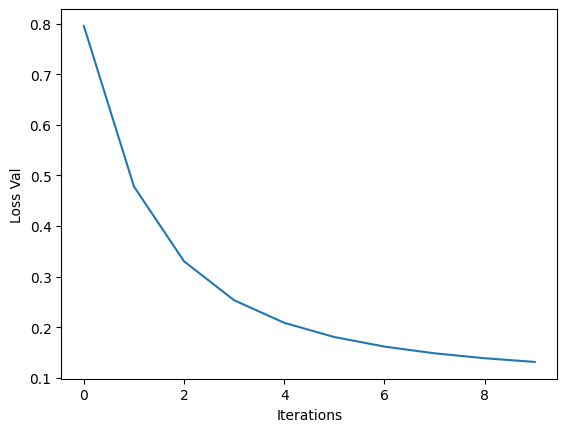

In [72]:
# Initialize a Pytorch MLP

# Initialize a standard SGD optimizer using torch.optim library
# nNN.parameters() return a list of all the paramters in the network. This paramters
# are automatically registered if declared in the __init__ function of an object nn.Module
# The optimizer stores the reference of this paramters in order to update them during optimization
optimizer = torch.optim.SGD(NN.parameters(), lr=.01)

# Convert 'Label' column to NumPy array and then to torch tensor
y = first_100_elements['Label'].to_numpy()
y = torch.tensor(y, dtype=torch.float32)

# Convert all other columns to NumPy array and then to torch tensor
X = first_100_elements.drop(['Label'], axis=1).to_numpy()
X = torch.tensor(X,dtype=torch.float32)

#Train MLP using Pytorch:
list_loss = train_PyTorch(NN,X,y,optimizer = optimizer)

# Plot the evolution of the loss function during training
plt.plot(list_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss Val')